# Vamos montar um estratégia Long & Short de Momentum 6M com composição mensal: 

# Primeiro importamos os dados necessarios: 

In [1]:
import pandas as pd 
from pandas_datareader import data as wb 
import matplotlib.pyplot as plt 
import numpy as np 

# Agora importamos os dados a partir de uma lista de tickers: 

In [2]:
tickers = ['ABEV3.SA','LREN3.SA','PETR4.SA','VALE3.SA','PSSA3.SA','POMO4.SA','LAME4.SA','MRFG3.SA','BBAS3.SA','ITUB4.SA'\
              ,'BBDC4.SA','USIM5.SA','BRFS3.SA','CIEL3.SA','CMIG4.SA','GGBR3.SA','CSAN3.SA','SULA11.SA','SBSP3.SA','TOTS3.SA'\
              ,'WEGE3.SA','EGIE3.SA','SANB11.SA','RENT3.SA','HYPE3.SA','DTEX3.SA','FLRY3.SA','MULT3.SA','BRML3.SA','MRVE3.SA'\
              ,'CPFE3.SA','BTOW3.SA','EMBR3.SA','JBSS3.SA','TIMP3.SA','IGTA3.SA','GOLL4.SA','ENBR3.SA','CYRE3.SA','BRAP4.SA'\
              ,'CCRO3.SA','BEEF3.SA','HGTX3.SA','VIVT4.SA','CESP3.SA','ABCB4.SA','BEES4.SA','CGAS5.SA','BRKM5.SA',\
              'CGRA3.SA','CPFE3.SA','CPLE3.SA','CSMG3.SA','CSNA3.SA','ETER3.SA','RAPT4.SA','GFSA3.SA','LIGT3.SA','SMTO3.SA',\
              'MDIA3.SA']

daily_prices = pd.DataFrame()

for i in tickers: 
    daily_prices[i]=wb.DataReader(i,data_source='yahoo',start='2010-01-01')['Adj Close']

# Separamos a base em meses e dias e calcular os retornos: 

In [55]:
#Fazemos um dataframe com os preços do último dia de cada mês:
monthly_prices = daily_prices.groupby([daily_prices.index.year,daily_prices.index.month]).tail(1)

#Fazemos um dataframe com os retornos diários: 
daily_returns = daily_prices.pct_change()

#Fazemos um dataframe com os retornos mensais: 
monthly_returns = monthly_prices.pct_change()

#Fazemos um dataframe com os retornos de seis meses para cada mês: 
six_months_returns = monthly_prices/monthly_prices.shift(6)-1

# Calculamos os pesos de cada final de mês:

In [56]:
#Criamos um dataframe aonde terá os pesos de cada mês: 
monthly_weights_pct = monthly_prices.copy()
monthly_weights_pct[:]=0

#Definimos o % que compraremos e o % que venderemos: 
q = 0.33 

#Definimos o % do patrimônio que estaremos long e o % que estaremos short: 
long_position = 1.3
short_position = 0.3

for i in monthly_weights_pct.index[6:]: 
    #Contamos o número de ações na data:
    n_stocks = six_months_returns.loc[i].count()
    #Vemos quais as q*100% melhores e pegamos os seus tickers:
    winner_stocks= six_months_returns.loc[i].dropna().sort_values().tail(int(n_stocks*q)).index.to_list()
    losser_stocks = six_months_returns.loc[i].dropna().sort_values().head(int(n_stocks*q)).index.to_list()
    #Atribuimos pesos iguais para todas long e short:
    monthly_weights_pct.loc[i][winner_stocks]=(1/len(winner_stocks))*long_position
    monthly_weights_pct.loc[i][losser_stocks]=(-1/len(losser_stocks))*short_position

# Calculamos os retornos e performance mensal da estratégia: 

In [57]:
#Múltiplicamos os retornos de cada mês pelo peso do final do mês anterior: 
strategy_monthly_returns = monthly_returns.mul(monthly_weights_pct.shift(1),axis=1).sum(axis=1)
strategy_monthly_performance = strategy_monthly_returns.add(1).cumprod()

# Calculamos os retornos diários e a performance diária da estratégia:

In [58]:
#Vamos calcular os pesos diários crescendo os mensais com os retornos diários: 
daily_weights = daily_returns.copy()
daily_weights[:]=0

#Inserimos os pesos do final de cada mês: 
for i in monthly_weights_pct.index:
    daily_weights.loc[i]=monthly_weights_pct.loc[i]

#Definimos o "norm position": 
norm_position = daily_weights.sum(axis=1)
norm_position[:]=0
    
#Crescemos os pesos com os retornos de cada mês e inserimos os valores no norm_position: 
for i in range(len(daily_weights)):
    if daily_weights.index[i] not in monthly_weights_pct.index: 
        daily_weights.iloc[i]=daily_weights.iloc[i-1]*(1+daily_returns.iloc[i])
        norm_position.iloc[i]=norm_position.iloc[i-1]+(daily_weights.iloc[i]-daily_weights.iloc[i-1]).sum()
    else: 
        norm_position.iloc[i]=1

daily_weights_pct = daily_weights.div(norm_position,axis=0)
strategy_daily_returns = daily_returns.mul(daily_weights_pct.shift(1),axis=1).sum(axis=1)
strategy_daily_performance = strategy_daily_returns.loc['2010-08':].add(1).cumprod()

# Calculamos como performou a carteira buy & hold: 

In [59]:
start_end_daily_returns = daily_prices.pct_change().loc['2010-08':]
buy_hold_daily_performance = start_end_daily_returns.add(1).cumprod().mean(axis=1)
buy_hold_daily_returns=buy_hold_daily_performance.pct_change()

# Plotamos os resultados: 

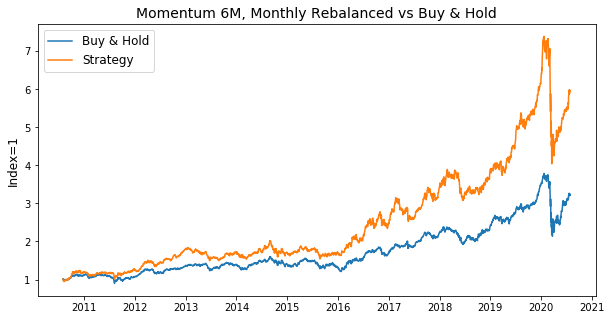

Momentum CAGR: 0.19942527740673333 
Momentum Vol: 0.22560076477705251 
Momentum Max Drawdown: -0.45314628536891255

 
Buy & Hold CAGR: 0.12736756617181033 
Buy & Hold Vol: 0.203097197644068 
Buy & Hold Max Drawdown: -0.43517975857579394


In [60]:
plt.figure(figsize=(10,5))
plt.plot(buy_hold_daily_performance,label='Buy & Hold')
plt.plot(strategy_daily_performance,label='Strategy')
plt.title('Momentum 6M, Monthly Rebalanced vs Buy & Hold',fontsize=14)
plt.ylabel('Index=1',fontsize=12)
plt.legend(loc='upper left',fontsize=12)
plt.show()

cagr = strategy_daily_performance.iloc[-1]**(252/len(strategy_daily_performance))-1
vol = strategy_daily_returns.std()*252**0.5
maxdrawdown = min(strategy_daily_performance/strategy_daily_performance.cummax()-1)

buy_hold_cagr = buy_hold_daily_performance.iloc[-1]**(252/len(buy_hold_daily_performance))-1
buy_hold_vol = buy_hold_daily_returns.std()*252**0.5
buy_hold_maxdrawdown = min(buy_hold_daily_performance/buy_hold_daily_performance.cummax()-1)

print('Momentum CAGR: '+str(cagr), '\nMomentum Vol: '+str(vol),'\nMomentum Max Drawdown: '+str(maxdrawdown))
print('\n','\nBuy & Hold CAGR: '+str(buy_hold_cagr), '\nBuy & Hold Vol: '+str(buy_hold_vol),\
            '\nBuy & Hold Max Drawdown: '+str(buy_hold_maxdrawdown))

# Plotamos os resultados em Log: 

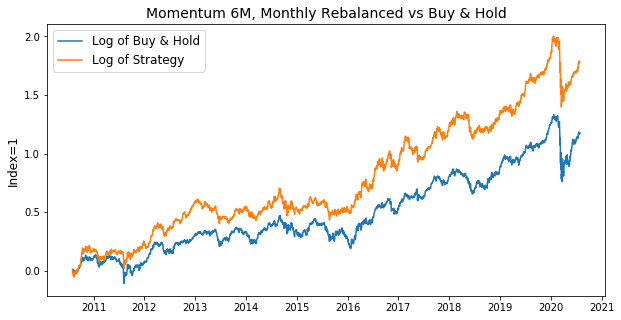

Momentum CAGR: 0.19942527740673333 
Momentum Vol: 0.22560076477705251 
Momentum Max Drawdown: -0.45314628536891255

 
Buy & Hold CAGR: 0.12736756617181033 
Buy & Hold Vol: 0.203097197644068 
Buy & Hold Max Drawdown: -0.43517975857579394


In [61]:
plt.figure(figsize=(10,5))
plt.plot(np.log(buy_hold_daily_performance),label='Log of Buy & Hold')
plt.plot(np.log(strategy_daily_performance),label='Log of Strategy')
plt.title('Momentum 6M, Monthly Rebalanced vs Buy & Hold',fontsize=14)
plt.ylabel('Index=1',fontsize=12)
plt.legend(loc='upper left',fontsize=12)
plt.show()

cagr = strategy_daily_performance.iloc[-1]**(252/len(strategy_daily_performance))-1
vol = strategy_daily_returns.std()*252**0.5
maxdrawdown = min(strategy_daily_performance/strategy_daily_performance.cummax()-1)

buy_hold_cagr = buy_hold_daily_performance.iloc[-1]**(252/len(buy_hold_daily_performance))-1
buy_hold_vol = buy_hold_daily_returns.std()*252**0.5
buy_hold_maxdrawdown = min(buy_hold_daily_performance/buy_hold_daily_performance.cummax()-1)

print('Momentum CAGR: '+str(cagr), '\nMomentum Vol: '+str(vol),'\nMomentum Max Drawdown: '+str(maxdrawdown))
print('\n','\nBuy & Hold CAGR: '+str(buy_hold_cagr), '\nBuy & Hold Vol: '+str(buy_hold_vol),\
            '\nBuy & Hold Max Drawdown: '+str(buy_hold_maxdrawdown))

# Montamos uma tabela com os retornos anuais: 

In [62]:
results = pd.DataFrame()
results['Strategy'] = strategy_daily_performance.resample('Y',kind='period').last().pct_change()*100
results['Buy & Hold']=buy_hold_daily_performance.resample('Y',kind='period').last().pct_change()*100
results.loc['2010']['Strategy'] = (strategy_daily_performance.resample('Y').last()[0]-1)*100
results.loc['2010']['Buy & Hold'] = (buy_hold_daily_performance.resample('Y').last()[0]-1)*100
results 

,Strategy,Buy & Hold
Date,,
2010,20.826377,12.566438
2011,5.097468,-5.430172
2012,41.804162,27.329321
2013,-3.884895,3.244160
2014,-0.867319,0.920220
2015,0.192662,-6.056219
2016,44.936288,28.607579
2017,36.318729,29.977984
2018,11.865720,6.123619
